# What's cooking? Text classification in Tensor Flow

The task is to guess the cuisine based on cooking receipts.

Data files are provided on Kaggle https://www.kaggle.com/c/whats-cooking

The solution is based on the library *scikit-learn* with the *TensorFlow* backend.
The code shows how to train a logistic classifier by *stochastic gradient descent* on the bag-of-words model, how to record and visualize training statistcs and computation grahps and how to handle imbalanced data by assigning class weights to the scoring metric.

In [1]:
import tensorflow as tf
import pandas as pnd
import numpy as np
import re
import nltk
import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt

## Data extraction

In [2]:
# path to data files
train_data_path = 'train.json'

data = pnd.read_json(train_data_path)

# have a look
data[:10]

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [3]:
y = data['cuisine']
X = data.drop(['id','cuisine'],axis=1)

In [4]:
def preprocess(X):
    X['ingredients'] = X['ingredients'].apply(lambda t: ','.join(t))
    X['ingredients'] = X['ingredients'].astype(str)
    return X

X = preprocess(X)
X[0:10]

,ingredients
0,"romaine lettuce,black olives,grape tomatoes,ga..."
1,"plain flour,ground pepper,salt,tomatoes,ground..."
2,"eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,"water,vegetable oil,wheat,salt"
4,"black pepper,shallots,cornflour,cayenne pepper..."
5,"plain flour,sugar,butter,eggs,fresh ginger roo..."
6,"olive oil,salt,medium shrimp,pepper,garlic,cho..."
7,"sugar,pistachio nuts,white almond bark,flour,v..."
8,"olive oil,purple onion,fresh pineapple,pork,po..."
9,"chopped tomatoes,fresh basil,garlic,extra-virg..."


## Building the bag-of-words model

In [5]:
# build a tokenizer

pattern = r'[^,]+'
pattern = re.compile(pattern)
stemmer = nltk.stem.PorterStemmer()
def tokenize(text):
    tokens = pattern.findall(text)
    return [stemmer.stem(i) for i in tokens]

print( tokenize(str( X.loc[0].ingredients )) )

['romaine lettuc', 'black ol', 'grape tomato', 'garlic', 'pepper', 'purple onion', 'season', 'garbanzo bean', 'feta cheese crumbl']


In [6]:
# build the dictionary

#counts = TfidfVectorizer(min_df=3,tokenizer=tokenize, norm=None, use_idf=False).fit(X['ingredients'])
counts = CountVectorizer(min_df=3,tokenizer=tokenize).fit(X['ingredients'])
voc_size = len(counts.vocabulary_)
print('Vocabulary is of size {0}'.format(voc_size))

Vocabulary is of size 4159


In [7]:
# do a train-test split

X_train0, X_test0, y_train0, y_test0 = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=11)

In [8]:
# build the document-term matrix

X_train_f = counts.transform(X_train0['ingredients'])
X_test_f = counts.transform(X_test0['ingredients'])

In [9]:
# encode targets

class_name = y_train0.unique()

y_train = y_train0.apply(lambda t: (class_name==t).argmax())
y_test = y_test0.apply(lambda t: (class_name==t).argmax())

## Building a model in TensforFlow

In [46]:
# lunch the session and reset recording
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [47]:
# build the TensorFlow model

n_classes = y.unique().shape[0]
n_features = voc_size

# use uniform class weights for now
with tf.name_scope('class_weights'):
    tmp = np.ones( n_classes )
    w_class = tf.Variable(tmp.reshape(-1,1),dtype=np.float32,name='class_weights',trainable=False) 

# define the learning rate decay
with tf.name_scope('learning_rate'):
    global_step=tf.Variable(0, trainable=False)
    r_learn = tf.Variable(0.5, trainable=False)
    rate = tf.train.natural_exp_decay(r_learn, global_step, 100 ,0.001)

# data and target placeholders (the first dimension understood as the batch size, left empty!)
with tf.name_scope('input_data'):
    X1 = tf.placeholder(shape=[None,n_features], dtype=np.float32,name='x_data') # dim = [batch_size,n_features]
    y1 = tf.placeholder(shape=[None], dtype=tf.int32, name='y_data')  # dim = [batch_size]

# model coefficients
with tf.name_scope('model_coeff'):
    w = tf.Variable(tf.ones([n_features,n_classes]), name='weights')
    b = tf.Variable(tf.zeros([1,n_classes]), name='bias')

# model predictions and loss
with tf.name_scope('accuracy'):
    logits = tf.matmul(X1,w) + b # dim = [batch_size,n_classes]
    labels = tf.one_hot(y1,n_classes) # dim = [batch_size,n_classes]
    weights = tf.reduce_sum( tf.matmul(labels, w_class), 1 ) # dim = [batch_size]
    entropy = tf.losses.softmax_cross_entropy(logits = logits, onehot_labels = labels, weights = weights)
    loss = tf.reduce_mean(entropy)

# optimizer
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = rate).minimize(loss, global_step=global_step)

# initialize
sess.run(tf.global_variables_initializer())

# start recording
summary_writer = tf.summary.FileWriter('./logs', sess.graph)

In [48]:
# model testing 

def preds(mini_batch_size=1000):
    # note: this keeps the memory usage low, by unziping the sparse feature matrix in batches
    total_score = 0
    n_samples = X_test_f.shape[0]
    n_batch = math.ceil( n_samples / mini_batch_size )
    preds = []
    for i in range(n_batch): 
        i_batch = i*mini_batch_size
        X_b = X_test_f[ i*mini_batch_size:min( (i+1)*mini_batch_size,n_samples) ]
        y_b = y_test[ i*mini_batch_size:min( (i+1)*mini_batch_size,n_samples ) ]
        with tf.name_scope('predictions'):
            _, logits_batch = sess.run([loss, logits], feed_dict={X1:X_b.todense(),y1:y_b})
            odds = tf.nn.softmax(logits_batch)
            heaviest = sess.run(tf.argmax( odds, 1))
        preds.append(heaviest)
    return preds

def f1_score():
    y_pred = np.concatenate( preds() )
    return metrics.f1_score(y_test,y_pred,average='macro')
    

In [49]:
# model training and evaluation

test_accuracy = tf.Variable(0,dtype=tf.float32,trainable=False)

train_summ = tf.summary.scalar('train_loss', loss)
test_summ = tf.summary.scalar('test_accuracy', test_accuracy)

def train(mini_batch_size=100,rate=1,n_epochs=25, record=True):
    # note: this keeps the memory usage low, by unziping the sparse feature matrix in batches
    n_samples = X_train_f.shape[0]
    n_batch = int( n_samples / mini_batch_size )
    loss_history = np.empty(shape=[1],dtype=np.float32)
    # set the learning rate
    sess.run(r_learn.assign(rate))
    # start learning
    for _ in range(n_epochs):
        # do a full pass over data
        for i in range(n_batch): 
            i_batch = i*mini_batch_size
            X_b = X_train_f[ i*mini_batch_size:(i+1)*mini_batch_size ]
            y_b = y_train[ i*mini_batch_size:(i+1)*mini_batch_size ]
            summary,_, train_loss = sess.run([train_summ,optimizer,loss],feed_dict={X1:X_b.todense(),y1:y_b})
        loss_history = np.append(loss_history, train_loss )
        # record training score
        if record:
            summary_writer.add_summary(summary, global_step.eval())
        # compute and record testing score
        y_pred = np.concatenate( preds() )
        sess.run(test_accuracy.assign(f1_score()))
        summary = sess.run(test_summ)
        if record:
            summary_writer.add_summary(summary, global_step.eval())
    return loss_history
        
# plot the training curve

def plot_training(n_epochs=25):
    plt.plot(loss_history)
    plt.xlim([1,n_epochs])
    plt.xlabel('# epochs')
    plt.ylabel('train loss')
    plt.show()

## Evaluation

Since the classes are imbalanced, the more relevant score than accuracy is f1 score agregated on the class level (*macro*). This gives the estimate of how the model performs accorss the classes. 

Note that recording stats in real time affects the performance of the evaluation.

In [50]:
# train, evaulate and record

# disable warnings for undefined f1-score - will be replaced by 0
import warnings
warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

print('Evaluating model...')
loss_history = train(rate=0.7,n_epochs=100)
#plot_training(n_epochs=100)
y_pred = np.concatenate( preds() )
print('F1-score (micro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='micro')))
print('F1-score (macro-averaged)={0}'.format( f1_score()))

Evaluating model...
F1-score (micro-averaged)=0.7732338892147825
F1-score (macro-averaged)=0.6916574884142961


We can download and plot the recored training and testing statistics using the Tensorboard tool (in Tensorboard, they are interactive though)

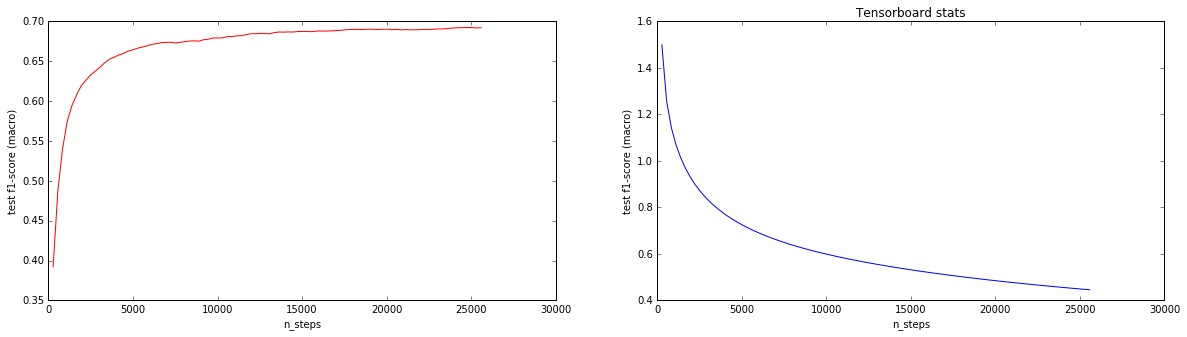

In [51]:
import os

fig = plt.figure(figsize=[20,5])

ax = fig.add_subplot(121)
ax.set_xlabel('n_steps')
ax.set_ylabel('test f1-score (macro)')
tmp = pnd.read_csv('/home/mskorski/Downloads/run_.-tag-test_accuracy.csv',header=0)
ax.plot(tmp['Step'],tmp['Value'],'red')

ax = fig.add_subplot(122)
ax.set_xlabel('n_steps')
ax.set_ylabel('test f1-score (macro)')
tmp = pnd.read_csv('/home/mskorski/Downloads/run_.-tag-train_loss.csv',header=0)
ax.plot(tmp['Step'],tmp['Value'])

plt.title('Tensorboard stats')
plt.show()

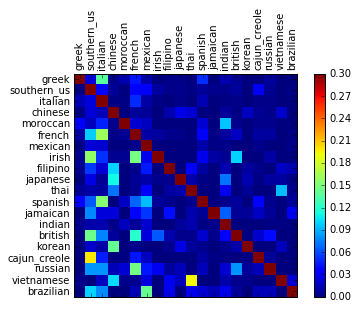

In [52]:
def report_confusion():
    tmp = np.float32( metrics.confusion_matrix(y_test, y_pred)) 
    for i in range(tmp.shape[0]):
        t = tmp[i].sum()
        tmp[i] = tmp[i]/t

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(tmp, vmin=0.0, vmax=0.3)
    fig.colorbar(cax)
    ticks = np.arange(0,n_classes,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(class_name, rotation=90)
    ax.set_yticklabels(class_name)
    plt.show()
    
report_confusion()

## Handling imbalanced data - class weights

By adding weights to less common classes we can trade errors, which otherwise concentrate on majority classes.

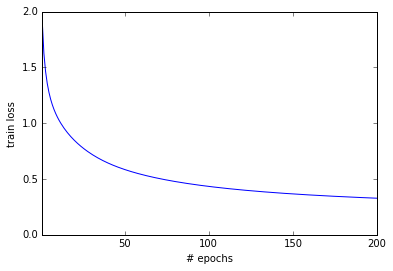

F1-score (micro-averaged)=0.7584010726556609
F1-score (macro-averaged)=0.6743241016799805


In [53]:
sess.run(tf.global_variables_initializer())

# modify the weights
tmp = np.array( pnd.crosstab(y_train,1))
tmp = np.ones(n_classes).reshape(-1,1) + 1*(tmp < np.mean(tmp))
sess.run(w_class.assign( tmp.reshape(-1,1)))

loss_history = train(n_epochs=200, rate=1)
plot_training(n_epochs=200)

y_pred = np.concatenate( preds() )
print('F1-score (micro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='micro')))
print('F1-score (macro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='macro')))

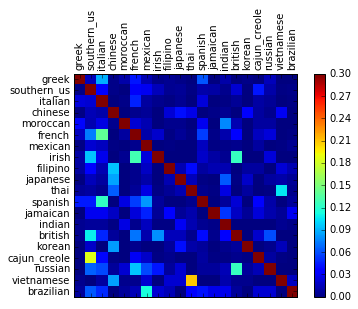

In [54]:
report_confusion()

In [39]:
sess.close()